In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
def rbf(data_point, center, var):
    #return np.exp(-1.0/(2*var)*(data_point - center)**2)
    #return np.exp(-1.0/(2*var)*(data_point - center).T.dot((data_point - center)))
    return np.exp(-1.0/(2*var)*np.diag((data_point - center).dot((data_point - center).T)))

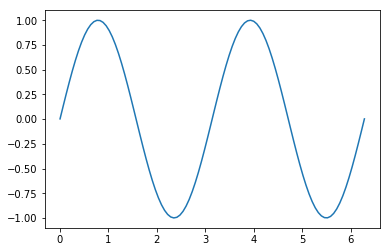

In [4]:
x = np.linspace(0.001, 2*np.pi + 0.001, 100)[:,np.newaxis]
y = np.sin(2*x)
plt.plot(x,y)

In [5]:
random_idx = np.random.permutation(len(x))

In [6]:
# play with this one
nCenters = 10

In [7]:
centers = [x[random_idx[i]] for i in range(nCenters)]

In [8]:
var = 0.4*np.ones(nCenters)

In [9]:
Phi = np.array([rbf(x, center, var) for center,var in zip(centers, var)])

In [10]:
weights = np.linalg.pinv(Phi).T.dot(y)

In [11]:
predictions = weights.T.dot(Phi).T

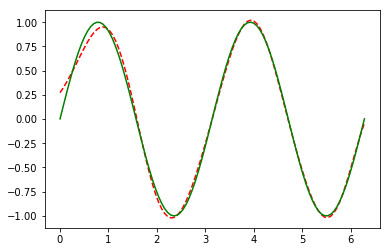

In [12]:
plt.plot(x,predictions, 'r--')
plt.plot(x,y, 'g-')

In [13]:
weights = np.random.normal(0,1, np.array(centers).shape)
bias = np.random.normal(0,1, 1)[:,np.newaxis]

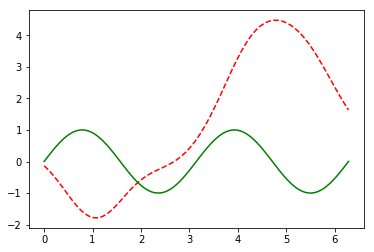

In [14]:
predictions = Phi.T.dot(weights) + bias*np.ones((Phi.shape[1],1))
plt.plot(x,predictions, 'r--')
plt.plot(x,y, 'g-')

In [15]:
#avg_res_error
np.mean((y - (Phi.T.dot(weights) + bias*np.ones((Phi.shape[1],1))))**2)

7.1169864828437062

In [16]:
eta = 0.05
epochs = 100
res_errors = []
for _ in range(epochs):
    for i in range(len(x)):
        error =  y[i] - (Phi[:,i].T.dot(weights) + bias)
        delta_weight = Phi[:,i][:,np.newaxis].dot(error)
        delta_bias = error.sum()
        weights += eta*delta_weight
        bias += eta*delta_bias
    
    avg_res_error = np.mean((y - (Phi.T.dot(weights) + bias*np.ones((Phi.shape[1],1))))**2)
    res_errors.append(avg_res_error)

Final error is 0.0105994631917


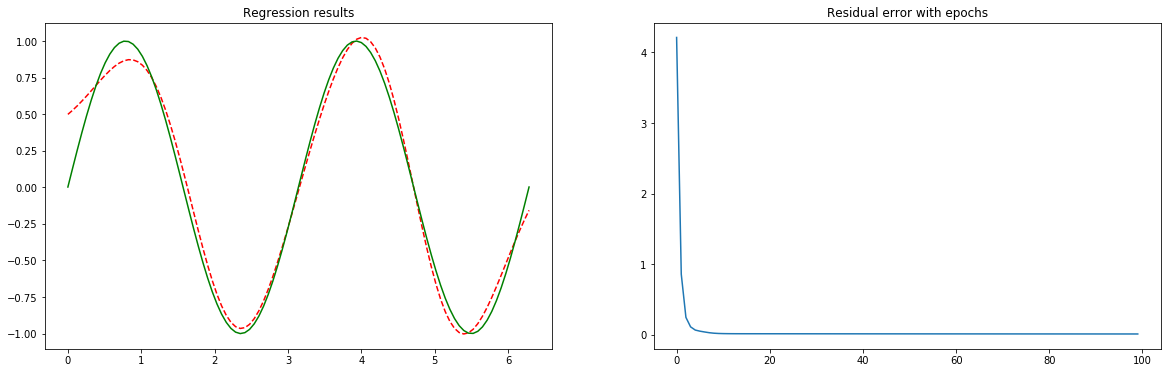

In [17]:
predictions = Phi.T.dot(weights) + bias*np.ones((Phi.shape[1],1))
fig = plt.figure(figsize=(20, 6)) 
plt.subplot(121)
plt.plot(x,predictions, 'r--')
plt.plot(x,y, 'g-')
plt.title('Regression results')
plt.subplot(122)
plt.title('Residual error with epochs')
plt.plot(res_errors)
print("Final error is",res_errors[-1])

In [18]:
# wrap everything up until now into a class
class RBFNet(object):
    def __init__(self, centers, variances, nDim = 1, eta = 0.05, epochs = 100):
        self.centers = centers
        self.variances = variances
        self.eta = eta
        self.epochs = epochs
        self.weights = np.random.normal(0,1, centers.shape)
        self.bias = np.random.normal(0,1, 1)[:,np.newaxis]
        
    def fitLeastSquares(self,x,y):
        self.Phi = np.asarray([rbf(x,center, var) \
                               for center,var in zip(self.centers, self.variances)])#.squeeze()
        self.weights = np.linalg.pinv(self.Phi).T.dot(y)
        self.bias = 0
        return self
    
    def fitDelta(self, x, y):
        self.Phi = np.asarray([rbf(x,center, var) \
                               for center,var in zip(self.centers, self.variances)])#.squeeze()
        self.res_errors = []
        for _ in range(self.epochs):
            for i in range(len(x)):
                error =  y[i] - (self.Phi[:,i].T.dot(self.weights) + self.bias)
                delta_weight = self.Phi[:,i][:,np.newaxis].dot(error)
                delta_bias = error.sum()
                self.weights += eta*delta_weight
                self.bias += eta*delta_bias

            avg_res_error = np.mean((y - (self.Phi.T.dot(self.weights) \
                                          + self.bias*np.ones((self.Phi.shape[1],1))))**2)
            self.res_errors.append(avg_res_error)
        return self
    
    def predict(self,x):
        self.Phi = np.asarray([rbf(x,center, var) \
                               for center,var in zip(self.centers, self.variances)])#.squeeze()
        #remember that the bias term is set to be zero for the least squares solution
        predictions = self.Phi.T.dot(self.weights) + self.bias*np.ones((self.Phi.shape[1],1))
        return predictions

In [19]:
x = np.linspace(0.001, 2*np.pi + 0.001, 100)[:,np.newaxis]
y = np.sin(2*x)

nCenters = 10
random_idx = np.random.permutation(len(x))
centers = [x[random_idx[i]] for i in range(nCenters)]
centers = np.array(centers)
variances = 0.4*np.ones(nCenters)
RBF = RBFNet(centers, variances)
RBF.fitLeastSquares(x,y)

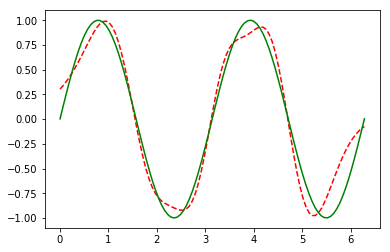

In [20]:
plt.plot(x, RBF.predict(x), 'r--')
plt.plot(x,y, 'g-')

In [21]:
x = np.linspace(0.00001, 2*np.pi + 0.00001, 100)[:,np.newaxis]
y = np.sin(2*x)

nCenters = 20
random_idx = np.random.permutation(len(x))
centers = [x[random_idx[i]] for i in range(nCenters)]
centers = np.array(centers)
variances = 0.4*np.ones(nCenters)
RBF = RBFNet(centers, variances)
RBF.fitDelta(x,y)

Final error is 0.00831635579662


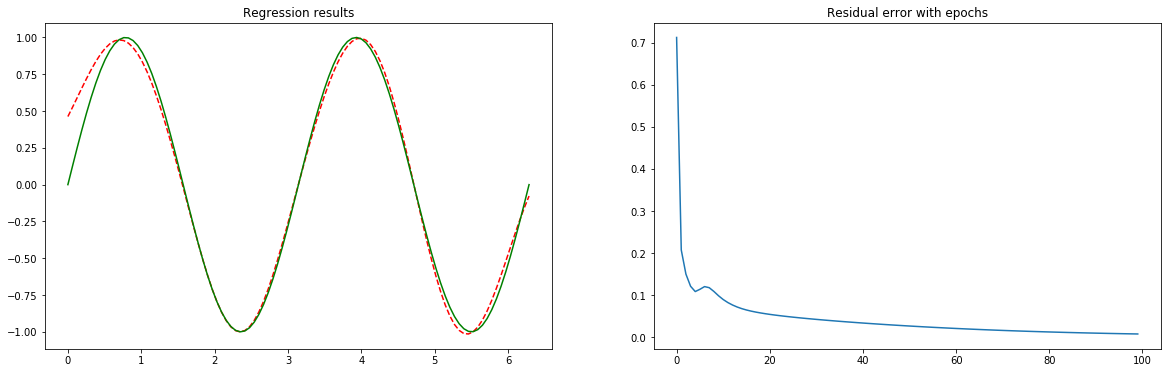

In [22]:
fig = plt.figure(figsize=(20, 6)) 
plt.subplot(121)
plt.title('Regression results')
plt.plot(x, RBF.predict(x), 'r--')
plt.plot(x,y, 'g-')
plt.subplot(122)
plt.title('Residual error with epochs')
plt.plot(RBF.res_errors)
print("Final error is", RBF.res_errors[-1])

## Find the centers using competitive learning

In [23]:
np.random.seed(2)

In [24]:
x = np.linspace(0.00001, 2*np.pi + 0.00001, 100)[:,np.newaxis]
y = np.sin(2*x)

# randomly select our centers again
nCenters = 12
random_idx = np.random.permutation(len(x))
centers = [x[random_idx[i]] for i in range(nCenters)]
centers = np.array(centers)
centers_random = centers.copy()

In [25]:
eta_C = 0.2
for i in range(100000):
    # find the closest center vector for a random input point
    sample = x[np.random.randint(len(x))]
    distances = np.sqrt(np.sum((centers - sample)**2, axis=1))
    closest_center_idx = np.argmin(distances)
    # update that center
    delta_center = sample - centers[closest_center_idx]
    centers[closest_center_idx] += eta_C*delta_center

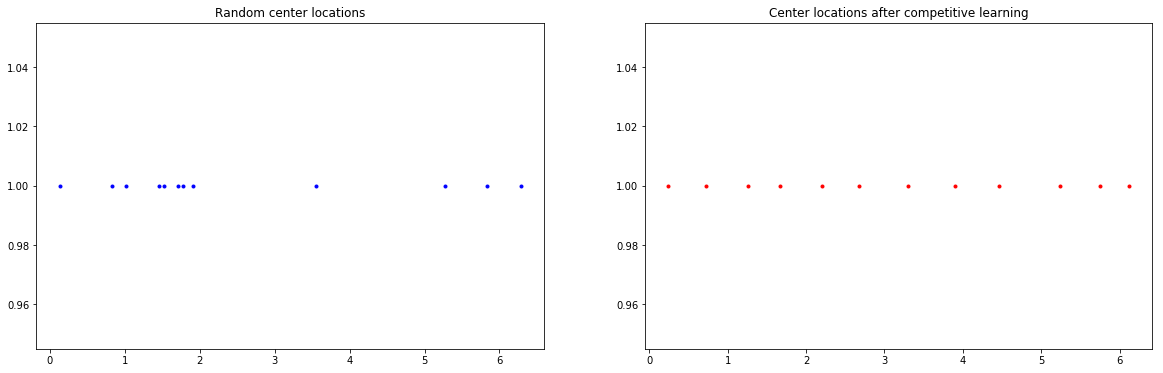

In [26]:
fig = plt.figure(figsize=(20, 6)) 
plt.subplot(121)
plt.title('Random center locations')
plt.plot(centers_random,np.ones(centers_random.shape), 'b.')
plt.subplot(122)
plt.title('Center locations after competitive learning')
plt.plot(centers,np.ones(centers.shape), 'r.')

In [27]:
variances = 0.4*np.ones(nCenters)
RBF = RBFNet(centers, variances, epochs=100)
RBF_random = RBFNet(centers_random, variances, epochs=100)
RBF.fitDelta(x,y)
RBF_random.fitDelta(x,y)

Final error with competitive centers is 0.0024669226136
Final error with random centers is 0.0436629461831


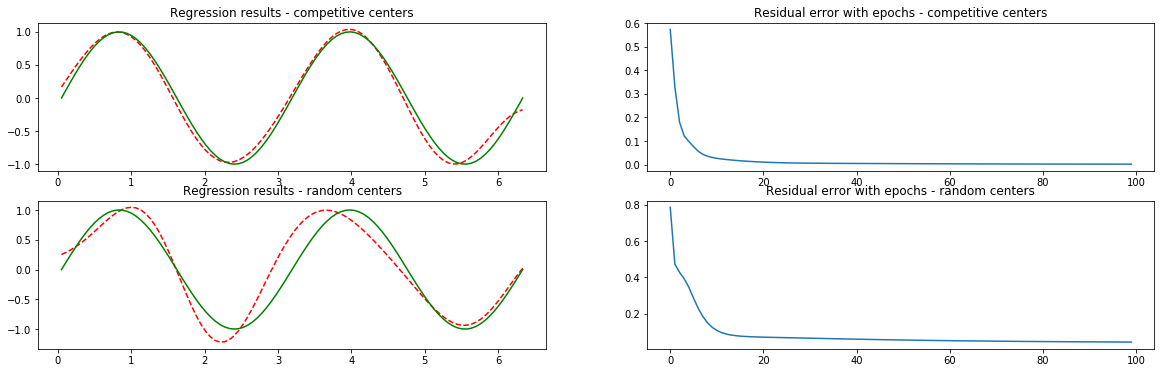

In [28]:
x_test = np.linspace(0.05, 2*np.pi + 0.05, 100)[:,np.newaxis]
y_test = np.sin(2*x)
fig = plt.figure(figsize=(20, 6)) 
plt.subplot(221)
plt.title('Regression results - competitive centers')
plt.plot(x_test, RBF.predict(x_test), 'r--')
plt.plot(x_test,y_test, 'g-')
plt.subplot(222)
plt.title('Residual error with epochs - competitive centers')
plt.plot(RBF.res_errors)
print("Final error with competitive centers is", RBF.res_errors[-1])

plt.subplot(223)
plt.title('Regression results - random centers')
plt.plot(x_test, RBF_random.predict(x_test), 'r--')
plt.plot(x_test,y_test, 'g-')
plt.subplot(224)
plt.title('Residual error with epochs - random centers')
plt.plot(RBF_random.res_errors)
print("Final error with random centers is", RBF_random.res_errors[-1])

### Try 2D data

In [29]:
import csv

In [30]:
angle_vel = []
dist_height = []
with open('ballist.dat', 'r') as File:
    output = csv.reader(File, delimiter='\t')
    for row in output:
        angle_vel.append(np.fromstring(row[0], dtype=float, sep=' '))
        dist_height.append(np.fromstring(row[1], dtype=float, sep=' '))
angle_vel = np.array(angle_vel)
dist_height = np.array(dist_height)

In [31]:
angle_vel_test = []
dist_height_test = []
with open('balltest.dat', 'r') as File:
    output = csv.reader(File, delimiter='\t')
    for row in output:
        angle_vel_test.append(np.fromstring(row[0], dtype=float, sep=' '))
        dist_height_test.append(np.fromstring(row[1], dtype=float, sep=' '))
angle_vel_test = np.array(angle_vel_test)
dist_height_test = np.array(dist_height_test)

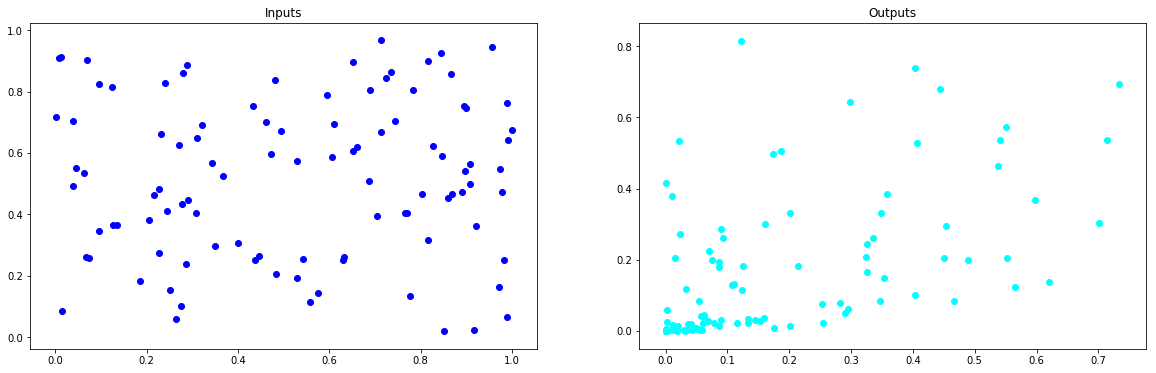

In [32]:
fig = plt.figure(figsize=(20,6))
plt.subplot(121)
plt.title('Inputs')
plt.scatter(angle_vel[:,0],angle_vel[:,1], color='blue')
plt.subplot(122)
plt.title('Outputs')
plt.scatter(dist_height[:,0],dist_height[:,1], color='cyan')

In [64]:
np.random.seed(5)

In [65]:
# randomly select our centers again
nCenters = 20
random_idx = np.random.permutation(len(angle_vel))
centers = [angle_vel[random_idx[i]] for i in range(nCenters)]
centers = np.array(centers)
centers_random = centers.copy()

In [66]:
from scipy.spatial import Voronoi, voronoi_plot_2d

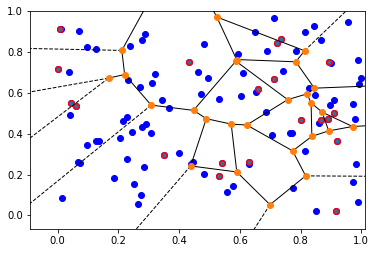

In [67]:
vor = Voronoi(centers_random)
a = voronoi_plot_2d(vor)
plt.scatter(angle_vel[:,0],angle_vel[:,1], color='blue')
plt.scatter(centers_random[:,0],centers_random[:,1], color='red')

In [68]:
eta_C = 0.2
for i in range(100000):
    # find the closest center vector for a random input point
    sample = angle_vel[np.random.randint(len(angle_vel))]
    distances = np.sqrt(np.sum((centers - sample)**2, axis=1))
    closest_center_idx = np.argmin(distances)
    # update that center
    delta_center = sample - centers[closest_center_idx]
    centers[closest_center_idx] += eta_C*delta_center

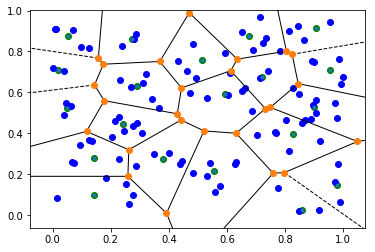

In [69]:
vor = Voronoi(centers)
_ = voronoi_plot_2d(vor)
plt.scatter(centers[:,0],centers[:,1], color='green')
plt.scatter(angle_vel[:,0],angle_vel[:,1], color='blue')

In [70]:
#variances = 0.02*np.ones(centers.shape[0])

In [71]:
# find the closest center idx's for each point in the input set
closest_centers = np.argmin(np.array([np.linalg.norm(angle_vel - center, axis=1) \
                                      for center in centers]), axis=0)
variances=np.zeros(centers.shape[0])
# for each group located at a center, find the spatial variance of that group
for i in range(centers.shape[0]):
    variances[i] = np.linalg.norm(angle_vel[closest_centers==i] - np.mean(angle_vel[closest_centers==i],\
                                                                          axis=0), axis=1).mean()

In [72]:
RBF = RBFNet(centers, variances, epochs=1000)
RBF.fitDelta(angle_vel,dist_height)

Final error with competitive centers is 0.000363816351441


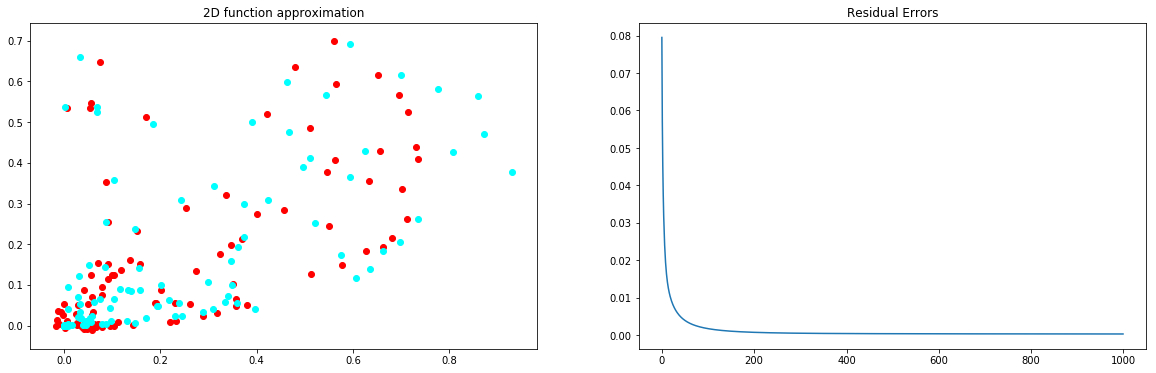

In [75]:
fig = plt.figure(figsize=(20,6))
plt.subplot(121)
plt.scatter(RBF.predict(angle_vel_test)[:,0], RBF.predict(angle_vel_test)[:,1],color='red')
plt.scatter(dist_height_test[:,0],dist_height_test[:,1], color='cyan')
plt.title('2D function approximation')
plt.subplot(122)
plt.plot(RBF.res_errors)
plt.title('Residual Errors')
print("Final error with competitive centers is", RBF.res_errors[-1])